This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

In [2]:
# Imports
import numpy as np
import math

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Grab image from files
img_names = glob.glob('images/*C1arrows.png')
img = Image.open(img_names[0])
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))

img = img.convert('L')
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))
img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))

#img.show()

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [4]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lens_sz/2.0 +x
    lens_corner_y=height/2.0 - lens_sz/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

In [15]:
# adjustable variables
lens_sz = 30
degree_num = 72
translation_num = 5
rng = np.random.default_rng(451)

image_list = []

# this range depends on image size and lens size such that the lens doesn't come off the page
lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0

degrees = np.linspace(0, 360, degree_num)
# intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
# intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)

intervals_x = rng.integers((-1)*lens_range, lens_range, size = translation_num)
#print(intervals_x)
intervals_y = rng.integers((-1)*lens_range, lens_range, size = translation_num)

# take snapshot images
for d in degrees:
    #print(d)
    rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
    for x in intervals_x:
        for y in intervals_y:
            image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
    
# Turn images into array of data
data = []
x=0
for i in image_list:
    img_arr = np.asarray(i)
    data.append(img_arr.reshape(-1))
data = np.array(data)


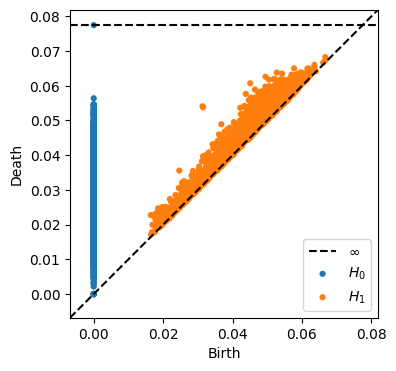

In [20]:
# make persistent homology plot with ripser
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

In [7]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [ ]:
store_snapshots(image_list)

In [21]:
# see how many points are persisting
H1 = res['dgms'][1].tolist() # all intervals in H1
d = []
for pair in H1: 
    d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
d.sort(reverse = True) # sorting from longest to shortest intervals
d

[0.022756781429052353,
 0.022299595177173615,
 0.01564013585448265,
 0.013848420232534409,
 0.013113349676132202,
 0.012462012469768524,
 0.012150228023529053,
 0.01146843284368515,
 0.011385805904865265,
 0.011300850659608841,
 0.011177517473697662,
 0.011076390743255615,
 0.011055614799261093,
 0.010942917317152023,
 0.0109185092151165,
 0.010790608823299408,
 0.010388419032096863,
 0.010377209633588791,
 0.010323900729417801,
 0.010303527116775513,
 0.01013541966676712,
 0.010097876191139221,
 0.010025974363088608,
 0.010010235011577606,
 0.00994628295302391,
 0.009926632046699524,
 0.00988829880952835,
 0.009866338223218918,
 0.009863529354333878,
 0.00984010100364685,
 0.009481579065322876,
 0.009449191391468048,
 0.009428400546312332,
 0.009425226598978043,
 0.009278282523155212,
 0.009240198880434036,
 0.009225782006978989,
 0.009205255657434464,
 0.009156372398138046,
 0.009052388370037079,
 0.009029779583215714,
 0.008976303040981293,
 0.008953075855970383,
 0.0089465752243995